# **Hand Recognization**
<br><br>

## **Tổng quan**

**Vấn đề**

Do mô hình phát hiện ảnh thật và gian lận chưa tốt, nên cần 1 đảm bảo khác để xác định được người thực sự ở trước camera là người thật. Giải pháp: sử dụng nhận diện tư thế tay

**Pipeline**

Mô hình nhận diện thật giả 

--> Nếu là giả: không làm gì

--> Nếu là thật: qua 1 lớp kiểm tra nữa là handrecognization

--> Nếu nhận diện bàn tay đúng 

--> FaceRecognization

**Công cụ**

**MediaPipe** hỗ trợ mô hình phát hiện và nhận diện tư thế tay

## **Mediapipe nhận diện tay**

**Mediapipe** cung cấp các tác vụ:

* Phát hiện tay
* Ước lượng tư thế tay
* Phân loại tay trái phải

**Import các gói cần thiết**

```python
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
```

### **Các hàm quan trọng**

#### **Tải mô hình nhận diện bàn tay**

Tải mô hình `hand_landmarker.task` ở trên trang https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker?hl=vi#models và lưu vào thư mục dự ánh

#### **Khởi tạo đối tượng phát hiện và nhận diện tay**

##### `vision.HandLandmarker.create_from_options`

* Tham số: 
    * `options`: Là một đối tượng `vision.HandLandmarkerOptions` chứa các thông tin config để khởi tạo đối tượng `HandLandmarker`


```python
detector = vision.HandLandmarker.create_from_options(options)
```

##### `vision.HandLandmarkerOptions`

* Phương thức khởi tạo đối tượng `HandLandmarkerOptions` để truyền vào khởi tạo `HandLandmarker`

* Tham số:
    * `base_options`( Đối tượng `mediapipe.tasks.python.BaseOptions` ): Đường dẫn đến file mô hình pretrained của mô hình vừa tải về

    * `running_mode`(int): số nguyên là mã của chế độ xử lý( các chế độ xử lý ***IMAGE, VIDEO, LIVE_STREAM***). Để cho dễ nhớ, những số nguyên này được định nghĩa cố định là các hằng số và tên của các hằng số là những tên dễ nhớ và sẽ được sử dụng thay cho các số nguyên, và được bọc trong gói `vision.RunningMode`:
        * `vision.RunningMode.IMAGE`: Chế độ xử lý hình ảnh

        * `vision.RunningMode.VIDEO` : Chế độ xử lý video

        * `vision.RunningMode.LIVE_STEAM`: Ché độ xử lý dòng thời gian thực

    * `num_hand`(int): Số tay càn phát hiện

    * `min_hand_detection_confidence`(float): Ngưỡng tin cậy tối thiểu cho phát hiện tay( từ 0.0 - 1.0, mặc định 0.5)

    * `min_hand_presence_confidence`(float): Ngưỡng tin tối thiểu để coi tay xuất hiện trong khung hình, dùng cho chế độ VIDEO( mặc định 0.5)

    * `min_tracking_confidence`(float): Ngưỡng tin cậy để xác định các điểm landmark( mặc định 0.5)

##### `python.BaseOption`

* Hàm tải mô hình pretrain

* Tham số: 
    `model_asset_path`(string): tên file mô hình pretrained đã tải về( trong tác vụ này sử dụng `hand_ landmarker.task`)

* Sử dụng: Truyền kết quả của hàm này vào tham số `base_options` trong hàm khởi tạo `HandLandmarkerOption` để tải mô hình pretrained

#### **Hàm phát hiện tay**

##### `detector.detect`

* Hàm xử lý chế độ ảnh tĩnh: IMAGE

* Tham số:
    * `mp_image`: đối tượng `mediapipe.Image` chứa ảnh( ở định dạng RGB)

* Trả về: Một đối tượng dictionary chứa các trường sau:
    * `hand_landmarks`(list): danh sách các danh sách con, mỗi danh sách con là danh sách các điểm landmark của 1 tay phát hiện được. Mỗi điểm landmark là một dictionary với các trường: `x`, `y`, `z` là tọa độ của các điểm landmark

    * `handedness`: danh sách phân loại tay trái, phải với độ tin cậy

    * `world_landmark`:danh sách các điểm landmark trong không gian 3D thực tế

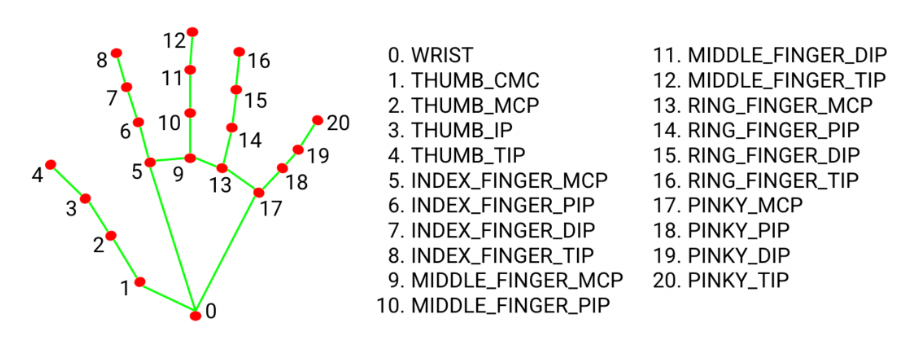

##### `detector.detect_for_video`

* Hàm xử lý chế độ video hoặc luồng stream webcam( chế độ VIDEO)

* Tham số:
    * `mp_image` : đối tượng `mediapipe.Image` chứa ảnh( ở định dạng RGB)

    * `timestamp_ms` : thời điểm trích xuất frame từ video( tính bằng ms). Tham số này truyền vào để mô hình kế thừa kết quả từ việc xử lý frame trước( tận dụng các kết quả điểm landmark, tay trái/phải,...), thay vì phải hoàn toàn chạy lại từ đầu các công việc: phát hiện tay, xác định các điểm mốc như hàm `detect` trên ảnh

* Trả về: giống như trên

#### **Vẽ đường nối lên trên video**

Dùng `cv2.circle` để vẽ các điểm landmarks, `cv2.line` để vẽ các đường nối

##### `cv2.circle`

* Hàm vẽ đường tròn

* Cú pháp:
    ```python
    cv2.circle(
        image, # numpy array là ảnh cần vẽ, ở chế độ RGB
        (x,y), # tọa độ tâm điểm
        4, # bán kính của điểm
        (0, 255, 0), # màu của điểm
    )
    ```
* Hàm làm thay đổi trực tiếp ảnh `image` đưa vào

##### `cv1.line`

* Hàm vẽ đoạn thẳng

* Cú pháp:
    ```python
    cv2.line(
        image,
        (x1, y1), # tuple là tọa độ điểm đầu đoạn thẳng
        (x2, y2), # tuple là tọa độ điểm cuối điểm cuối đoạn thẳng
        (0, 0, 255),
        2
    )

* Hàm thay đổi trực tiếp ảnh `image` đưa vào

##### **Vẽ lên ảnh**

* Chuyển đổi tạo độ lấy được từ kết quả `detect` về tọa độ thực tế( các điểm landmark lấy được đang có tọa độ chuẩn hóa 0-1):

    ```python
    h, w , _ = image.shape
    # lặp qua các bàn tay phát hiện được
    for hand in result.hand_landmarks:
        # lặp qua các điểm landmarks của 1 bàn tay
        for landmark in hand:
            # chuyển đổi các tọa độ về tọa độ thực tế:
            x = int(landmark.x*w)
            y = int(landmark.y*h)
            # vẽ điểm lên ảnh
            cv2.circle(image, (x,y), 4, (0, 255, 0))

    ```



## **Code test**

Dựa vào hình ảnh các điểm landmark trên lòng bàn tay, có thể viết 1 hàm để đếm số ngón tay đang giơ ra theo quy tắc sau:

* Một ngón tay duỗi ra hoàn toàn khi điểm đầu ngón tay đó nằm ngoài tất cả các điểm còn lại trên lòng bàn tay( là các điểm cực biên của vùng tạo bởi các điểm landmarks). Ví dụ, ngón tay cái duỗi ra hoàn toàn khi điểm 4 nằm ngoài vùng tạo bởi các điểm còn lại.

* Tuy nhiên, để đơn giản, ta sẽ chỉ so sánh điểm đầu của các ngón tay với các điểm trong cùng ngón tay đó và điểm gốc bàn tay: Ví dụ ngón cái:
    * Ngón tay duỗi khi vector có 2 đầu mút là landmark 3-4, 2-4, 1-4 sẽ khác chiều với vector có 2 đầu mút là điểm 1-0
    * Để xác định 2 vector khác chiều nhau thì cần phải xác định xem giá trị cos của góc tạo bởi 2 vector là âm hay dương. Tuy nhiên, việc tính cos là rất mất thời gian và chi phí không nhỏ, nhưng ta nhận thấy cos của góc tạo bởi 2 vector thì cùng dấu với tích vô hướng của 2 vector đó( vì `<a,b> = |a|*|b|*cos(a,b)`). Do đó ta sẽ tính tích vô hướng của 2 vector, điều này lại khá đơn giản

In [13]:
'''
    Hàm đếm số ngón tay đang duỗi ra trong lòng bàn tay
    _ Nhận vào: kết quả phát hiện tay
    _ Trả về: số ngón tay đang duỗi
'''
def count(result):
    final_result = 0
    # Duyệt qua các bàn tay( thông thường chỉ có 1 bàn tay được nhận diện)
    for hand in result.hand_landmarks:
        # Mỗi hand là 1 danh sách các điểm landmark

        # Kiểm tra xem ngón cái có đang duỗi không
        # Bằng cách tính tích vô hướng của vector (landmark[3], landmark[4]) và vector (landmark[3], landmark[1])
        a = (hand[4].x - hand[3].x, hand[4].y - hand[3].y, hand[4].z - hand[3].z)
        b = (hand[4].x - hand[2].x, hand[4].y - hand[2].y, hand[4].z - hand[2].z)
        c = (hand[4].x - hand[1].x, hand[4].y - hand[1].y, hand[4].z - hand[1].z)
        d = (hand[1].x - hand[0].x, hand[1].y - hand[0].y, hand[1].z - hand[0].z)
        check = (a[0]*d[0] + a[1]*d[1] >0 + a[2]*d[2]) and (b[0]*d[0] + b[1]*d[1]+ b[2]*d[2]>0 ) and (c[0]*d[0] + c[1]*d[1] + c[2]*d[2]>0) 
        final_result = (final_result + 1) if check else final_result

        # tương tự kiểm tra ngón trỏ
        a = (hand[8].x - hand[7].x, hand[8].y - hand[7].y, hand[8].z - hand[7].z)
        b = (hand[8].x - hand[6].x, hand[8].y - hand[6].y, hand[8].z - hand[6].z)
        c = (hand[8].x - hand[5].x, hand[8].y - hand[5].y, hand[8].z - hand[5].z)
        d = (hand[5].x - hand[0].x, hand[5].y - hand[0].y, hand[5].z - hand[0].z)
        check = (a[0]*d[0] + a[1]*d[1] >0 + a[2]*d[2]) and (b[0]*d[0] + b[1]*d[1]+ b[2]*d[2]>0 ) and (c[0]*d[0] + c[1]*d[1] + c[2]*d[2]>0) 
        final_result = (final_result + 1) if check else final_result

        # ngón giữa
        a = (hand[12].x - hand[11].x, hand[12].y - hand[11].y, hand[12].z - hand[11].z)
        b = (hand[12].x - hand[10].x, hand[12].y - hand[10].y, hand[12].z - hand[10].z)
        c = (hand[12].x - hand[9].x, hand[12].y - hand[9].y, hand[12].z - hand[9].z)
        d = (hand[9].x - hand[0].x, hand[9].y - hand[0].y, hand[9].z - hand[0].z)
        check = (a[0]*d[0] + a[1]*d[1] >0 + a[2]*d[2]) and (b[0]*d[0] + b[1]*d[1]+ b[2]*d[2]>0 ) and (c[0]*d[0] + c[1]*d[1] + c[2]*d[2]>0) 
        final_result = (final_result + 1) if check else final_result

        # ngón áp út
        a = (hand[16].x - hand[15].x, hand[16].y - hand[15].y, hand[16].z - hand[15].z)
        b = (hand[16].x - hand[14].x, hand[16].y - hand[14].y, hand[16].z - hand[14].z)
        c = (hand[16].x - hand[13].x, hand[16].y - hand[13].y, hand[16].z - hand[13].z)
        d = (hand[13].x - hand[0].x, hand[13].y - hand[0].y, hand[13].z - hand[0].z)
        check = (a[0]*d[0] + a[1]*d[1] >0 + a[2]*d[2]) and (b[0]*d[0] + b[1]*d[1]+ b[2]*d[2]>0 ) and (c[0]*d[0] + c[1]*d[1] + c[2]*d[2]>0) 
        final_result = (final_result + 1) if check else final_result

        # ngón út
        a = (hand[20].x - hand[19].x, hand[20].y - hand[19].y, hand[20].z - hand[19].z)
        b = (hand[20].x - hand[18].x, hand[20].y - hand[18].y, hand[20].z - hand[18].z)
        c = (hand[20].x - hand[17].x, hand[20].y - hand[17].y, hand[20].z - hand[17].z)
        d = (hand[17].x - hand[0].x, hand[17].y - hand[0].y, hand[17].z - hand[0].z)
        check = (a[0]*d[0] + a[1]*d[1] >0 + a[2]*d[2]) and (b[0]*d[0] + b[1]*d[1]+ b[2]*d[2]>0 ) and (c[0]*d[0] + c[1]*d[1] + c[2]*d[2]>0) 
        final_result = (final_result + 1) if check else final_result
        
    return final_result

In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), "CountFingersModel"))
sys.path.append(os.path.join(os.getcwd(), "LivenessNet"))

from CountFingersModel.utils import loadModel
from CountFingersModel.model import predict
from LivenessNet.util import loadModel as loadLivenessModel
from LivenessNet.modelFunction import predict as predictRealFake

checkpoin_path = os.path.join("CountFingersModel", "ckpt", "2200_epochs.pkl")
model = loadModel(checkpoin_path)

ckpt_path = os.path.join("LivenessNet","ckpt", "298_epochs.pkl")
LivenessModel = loadLivenessModel(ckpt_path)


Để xác định xem các điểm

In [3]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import random
import csv
import torch

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# Khởi tạo đối tượng đọc camera
camera = cv2.VideoCapture(0)
if not camera.isOpened():
    print("Khởi tạo camera không thành công")
height = camera.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = camera.get(cv2.CAP_PROP_FRAME_WIDTH)

# Khởi tạo mô hình nhận diện tay
base_options = python.BaseOptions(model_asset_path = "hand_landmarker.task")
option = vision.HandLandmarkerOptions(
    base_options = base_options,
    running_mode = vision.RunningMode.VIDEO,
    num_hands = 1,
    min_hand_detection_confidence = 0.5,
    min_hand_presence_confidence = 0.5,
    min_tracking_confidence = 0.5
)
detector = vision.HandLandmarker.create_from_options(option)

time_stamp = 0
ranNum = random.randint(0, 5)
os.makedirs("more_fake_data", exist_ok = True)

# Đọc từng frame
i = len(os.listdir("more_fake_data"))
while True:
    res, frame = camera.read()
    if not res:
        print("Đọc frame thất bại")
        break

    save_frame = frame.copy()
    # tạo 1 đối tượng Image( đây là đầu vào của hàm detect)
    rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format = mp.ImageFormat.SRGB, data=rgb_image)

    # phát hiện tay
    result = detector.detect_for_video(mp_image, time_stamp)
    time_stamp += int(1000/30)

    # Vẽ kết quả lên ảnh
    # Vẽ các điểm landmark
    
    # Lặp qua các tay
    for hand in result.hand_landmarks:
        # Lặp qua các điểm landmark
        for landmark in hand:
            # chuyển đổi các điểm landmark về tọa độ thực tế
            x = int(landmark.x * width)
            y = int(landmark.y * height)

            #Vẽ kết quả lên ảnh
            cv2.circle(
                frame,
                (x, y),
                4,
                (0, 255, 0),
                -1
            )
    
    
    
    # Đếm số ngón tay đang duỗi
    if len(result.hand_landmarks) != 0:
        result_landmark = []
        for hand in result.hand_landmarks:
            for landmark in hand:
                result_landmark.append(landmark.x)
                result_landmark.append(landmark.y)
                result_landmark.append(landmark.z)
        
        num = predict(model, result_landmark)
    else:
        num = -1

    if num == ranNum and len(result.hand_landmarks) != 0:
        color = (0,255,0)
    else:
        color = (0,0,255)

    # Nhận diện real/fake
    
    re_fa = predictRealFake(LivenessModel, rgb_image)
    if re_fa:
        print(f"\rreal", end="")
    else:
        print(f"\rfake", end="")
    if num == ranNum and len(result.hand_landmarks) != 0 and re_fa:
        cv2.circle(
            frame,
            (30,30),
            4,
            (0,255,0),
            4
        )

    else:
        cv2.circle(
            frame,
            (30,30),
            4,
            (0,0,255),
            4
        )
    # Viết số lên màn hình
    cv2.putText(
        frame,
        str(ranNum),
        (30, int(height/2)),
        fontFace=cv2.FONT_HERSHEY_COMPLEX,
        fontScale= 1.0,
        thickness=2,
        color=color
    )
    
    cv2.imshow(
        "Hand Recognization",
        frame
    )

    key = cv2.waitKey(2)
    if key in [ord('0'), ord('1'), ord('2'), ord('3'), ord('4'), ord('5')]:
        with open("data_for_count_model.csv", "a") as f:
            writer = csv.writer(f, delimiter=",")
            row = []
            for hand in result.hand_landmarks:
                for landmark in hand:
                    row.append(landmark.x)
                    row.append(landmark.y)
                    row.append(landmark.z)
            char_code = key & 0xFF
            row.append(chr(char_code))
            writer.writerow(row)
    if key == ord('r'):
        cv2.imwrite(os.path.join("more_fake_data", f"{i}_image.jpg"), save_frame)
        i +=1
    if key == ord('q'):
        break

camera.release()
cv2.destroyAllWindows()
    


fake

* 0: 1-213: 106
* 1: 215 - 693: 240
* 2: 695 - 1091: 200
* 3: 1093 - 2779: 845
* **4: 2781 - 5439: 1330**
* 5: 